In [1]:
%load_ext autoreload
%autoreload 2

# Active learning with Trieste

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path('../..') / 'cajal'))
sys.path.append(str(Path('..') / 'simulators'))
sys.path.append(str(Path('..') / 'online_neuro'))

In [3]:
from pathlib import Path
import tensorflow as tf
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from online_neuro.bayessian_optimizer import BayesianOptimizer, AskTellOptimizerHistory
from online_neuro.online_learning import build_model
from online_neuro.utils import CustomMinMaxScaler, generate_grids

from simulators.python.problems.toy_problems import circle, multiple_circles

from trieste.data import Dataset
from trieste.acquisition.function import BayesianActiveLearningByDisagreement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.bayesian_optimizer import Record
from trieste.observer import OBJECTIVE
from trieste import space

2025-02-06 17:37:59.493678: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 17:37:59.520424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 17:37:59.520451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 17:37:59.521364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 17:37:59.526328: I tensorflow/core/platform/cpu_feature_guar

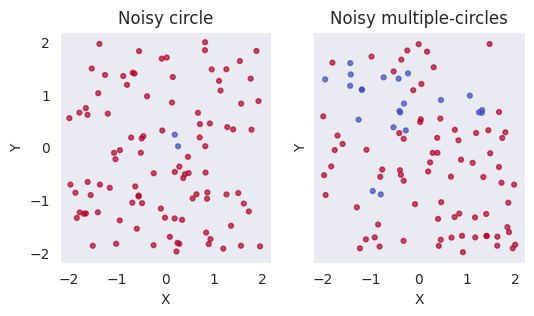

In [4]:
# Example data one circle
# Multiple circle example

noise_scaled=0.10
num_points = 100
center = np.array([0,0])

x0 = np.random.uniform(-2, 2, size=(num_points, 2))
y0 = circle(x0[:,0], x0[:,1], radius=0.4, noise=noise_scaled, center=center)
y0 = y0['observations']

radius = [0.5, 0.3, 0.8]
noise = [0.1, 0.01, 0.2]
center = [[1, 1], [-1, -1], [-1, 1]]
x1 = np.random.uniform(-2, 2, size=(num_points, 2))
y1 = multiple_circles(x0=x1[:,0], x1=x1[:,1], 
                     radius=radius,
                     noise=noise, 
                     center=center)


y1 = y1['observations']
fig, ax = plt.subplots(figsize=(6, 3), ncols=2, sharex=True, sharey=True)
ax[0].scatter(x0[:,0], x0[:,1], c=y0, cmap='coolwarm', alpha=0.7, s=12)
ax[0].set_title('Noisy circle')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].grid()

ax[1].scatter(x1[:,0], x1[:,1], c=y1, cmap='coolwarm', alpha=0.7, s=12)
ax[1].set_title('Noisy multiple-circles')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].grid()


In [5]:
# Partially initialize the function. 
# Replace init_fun with a class/call that returns either 0,1 for a classification problem, or a continuous value to minimize/maximize
radius = [0.5, 0.3, 0.8]
noise = [0.1, 0.01, 0.2]
center = [[1, 1], [-1, -1], [-1, 1]]

init_fun = partial(multiple_circles, 
                   radius=radius,
                   noise = noise,
                   center = center)

lb = [-2, -2]
ub = [2, 2]

val_data, test_data = generate_grids(2, 20, -2, 2)
search_space = space.Box(lower=[-1,-1],
                         upper=[1,1])

scaler = CustomMinMaxScaler(feature_min=lb,
                            feature_max=ub,
                            output_range=(-1,1))

In [6]:
# Even and intermediate samples to visualize/evaluate
test_data = np.concatenate([val_data, test_data],axis=0)
# We generate labels by setting noise to 0
test_data_scaled = scaler.transform(test_data)
test_labels = init_fun(x0=test_data[:,0], x1=test_data[:,1], noise=[0, 0, 0])
test_labels = test_labels['observations']

(-2.0, 2.0)

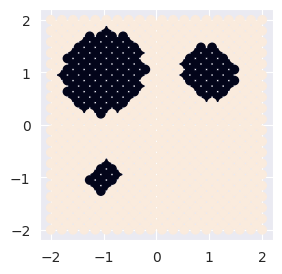

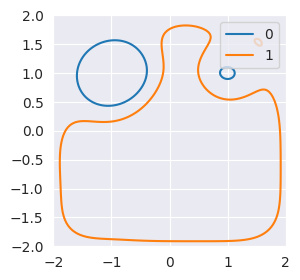

In [7]:
import seaborn as sns
# Ground truth (scatter)
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(test_data[:,0],test_data[:,1], c=test_labels)
# KDE approximation using Seaborn
fig, ax = plt.subplots(figsize=(3,3))
sns.kdeplot(x=test_data[:,0],y=test_data[:,1], hue=test_labels, levels=1,
            thresh=0.5,
            fill=False, ax=ax)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

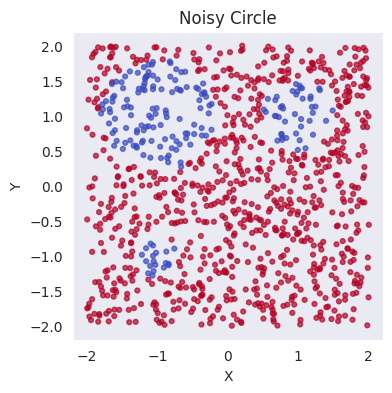

In [8]:
# The "Solution" at a large sample rate observed a large amount of samples and noise=0
x = np.random.uniform(-2, 2, size=(1000, 2))
y = init_fun(x[:,0], x[:,1], noise=[0, 0, 0])
y = y['observations']
plt.figure(figsize=(4, 4))
plt.scatter(x[:,0], x[:,1], c=y, cmap='coolwarm', alpha=0.7, s=12)
plt.title('Noisy Circle')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.axis('equal')
plt.show()

In [9]:
# Initial samples
init_samples = 50
qp_orig = search_space.sample(init_samples)
qp_orig = qp_orig.numpy()

if scaler:
    qp = scaler.inverse_transform(qp_orig)
    
col_names = ['x_1','x_2']
qp_df_init = pd.DataFrame(qp, columns=col_names)

In [10]:
# First observations
observations = init_fun(qp[:,0], qp[:,1])
observations = observations['observations']
observations = np.atleast_2d(observations).reshape(-1,1)
qp_df_init['observation'] = observations


In [11]:
qp.min(axis=0), qp.max(axis=0)

(array([-1.99710376, -1.99916995]), array([1.87843437, 1.92933606]))

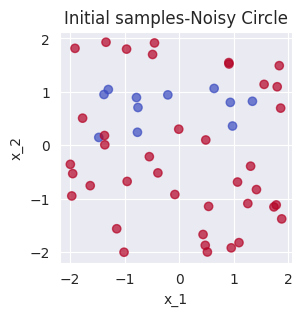

In [12]:
plt.figure(figsize=(3, 3))
plt.scatter(qp_df_init[col_names[0]], qp_df_init[col_names[1]], c=qp_df_init['observation'],
            cmap='coolwarm', alpha=0.7)
plt.xlabel(col_names[0])
plt.ylabel(col_names[1])
#plt.axis('equal')
plt.title("Initial samples-Noisy Circle")
plt.show()

In [13]:
# @Note. For some tensorflow reason observations need to be float even for classification problems.
# Trieste Dataset (X,y)
init_dataset = Dataset(query_points=tf.cast(qp_orig, tf.float64),
                       observations=tf.cast(observations, tf.float64))


In [14]:
# Methods that specify the type of model and acquisition function
model_config = {'classification':True,
                'variational':True,
                'sparse':False,
                'trainable_likelihood':True,
                'noise_free':True,
               }

save_results = False
save_path = 'models'
online_model = build_model(init_dataset,
                           search_space,
                           model_config)

acq = BayesianActiveLearningByDisagreement()
rule = EfficientGlobalOptimization(builder=acq,
                                   num_query_points=1 #A lot of models can only query 1 point at a time.
                                   )

ask_tell = AskTellOptimizerHistory(search_space = search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model = True,
                                   overwrite = True,
                                   track_path='models')

In [15]:
max_iters = 50
iter = 0

init_df = qp_df_init.copy()
qp_dfs = []
while iter <= max_iters:
    print(f"{iter}/{max_iters}",end='\r')
    #Request point to sample
    qp_orig = ask_tell.ask_and_save()
    qp_orig = qp_orig.numpy()

    if scaler:
        qp = scaler.inverse_transform(qp_orig)
        
    observations = init_fun(x0=qp[:,0], x1=qp[:,1])
    observations = observations['observations']
    observations = observations = np.atleast_2d(observations)

    tagged_output = Dataset(query_points=tf.cast(qp_orig, tf.float64), 
                            observations=tf.cast(observations, tf.float64))
    qp_df = pd.DataFrame(qp, columns = col_names)

    qp_df['observation'] = observations
    qp_dfs.append(qp_df)
    
    #First iteration (outside of the loop, it can also be done inside tho)
    ask_tell.tell(tagged_output)
    
    iter += 1

ask_tell.save()

In [16]:
qp_dfs = pd.concat(qp_dfs, ignore_index=True)

In [17]:
qp_dfs.head(3)

x_1       x_2  observation
0 -0.264477  1.369727            1
1 -1.889271  1.114945            1
2  1.514331  0.292546            1

In [18]:
init_df.head(3)

x_1       x_2  observation
0 -0.009596  0.302430            1
1 -1.997104 -0.355137            1
2 -0.209631  0.944082            0

In [19]:
init_df.shape, qp_dfs.shape

((50, 3), (51, 3))

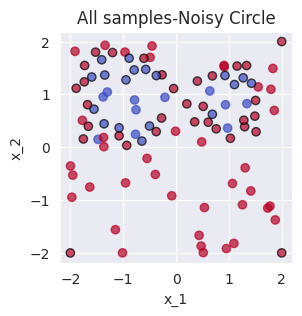

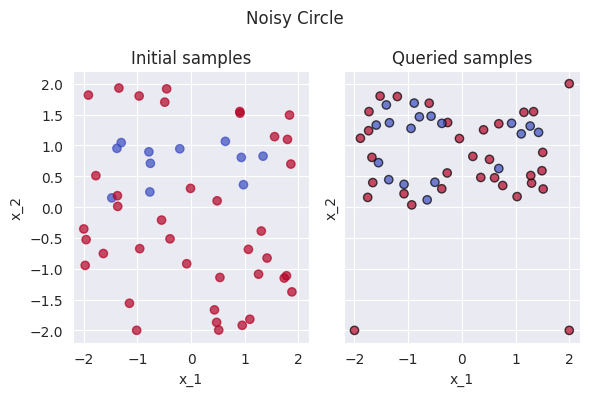

In [20]:
plt.figure(figsize=(3, 3))
plt.scatter(init_df['x_1'], init_df['x_2'], c=init_df['observation'],
            cmap='coolwarm', alpha=0.7, label='init_samples')
plt.scatter(qp_dfs['x_1'], qp_dfs['x_2'], c=qp_dfs['observation']+2,
            cmap='coolwarm', alpha=0.7, label='collected_samples',
           edgecolors='black')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.axis('equal')
plt.title("All samples-Noisy Circle")
plt.show()

fig, ax = plt.subplots(figsize=(6, 4), ncols=2, sharey=True, sharex=True)
ax[0].scatter(init_df['x_1'], init_df['x_2'], c=init_df['observation'],
            cmap='coolwarm', alpha=0.7, label='init_samples')
ax[1].scatter(qp_dfs['x_1'], qp_dfs['x_2'], c=qp_dfs['observation']+2,
            cmap='coolwarm', alpha=0.7, label='collected_samples',
           edgecolors='black')
ax[0].set_xlabel('x_1')
ax[1].set_xlabel('x_1')
ax[0].set_ylabel('x_2')
ax[1].set_ylabel('x_2')
ax[0].set_title("Initial samples")
ax[1].set_title("Queried samples")
fig.suptitle("Noisy Circle")
fig.tight_layout()
plt.show()

In [21]:
# 3D Plot to observe UB and LB of the predictions (notice that the predictions haven't been inverted to the range 0-1 (Bernoulli Distribution). Probably would be nice to adapt this.
from trieste.experimental.plotting.plotting_plotly import plot_model_predictions_plotly
fig = plot_model_predictions_plotly(ask_tell.model, search_space.lower, search_space.upper)
fig.show()

In [22]:
ask_tell.model.model

<gpflow.models.vgp.VGP object at 0x71537d88a0e0>
╒═════════════════════════╤══════════════════╤════════════════╤═══════════╤═════════════╤═════════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                    │ class            │ transform      │ prior     │ trainable   │ shape           │ dtype   │ value                                                │
╞═════════════════════════╪══════════════════╪════════════════╪═══════════╪═════════════╪═════════════════╪═════════╪══════════════════════════════════════════════════════╡
│ VGP.mean_function.c     │ Parameter        │ Identity       │           │ True        │ ()              │ float64 │ 13.56495                                             │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.variance     │ Parameter        │ Softplus       │           │ False       │ ()              │ float64 │ 100.0                                                │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.lengthscales │ Parameter        │ Softplus       │ LogNormal │ True        │ (2,)            │ float64 │ [0.3820902  0.51897287]                              │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.data[0]             │ ResourceVariable │                │           │ False       │ (None, 2)       │ float64 │ [[-0.00479784, 0.15121523...                         │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.data[1]             │ ResourceVariable │                │           │ False       │ (None, 1)       │ float64 │ [[1....                                              │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.num_data            │ Parameter        │ Identity       │           │ False       │ ()              │ int32   │ 101                                                  │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.q_mu                │ Parameter        │ Identity       │           │ True        │ (None, 1)       │ float64 │ [[-0.41567514...                                     │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.q_sqrt              │ Parameter        │ FillTriangular │           │ True        │ (1, None, None) │ float64 │ [[[3.29785609e-01, 0.00000000e+00, 0.00000000e+00... │
╘═════════════════════════╧══════════════════╧════════════════╧═══════════╧═════════════╧═════════════════╧═════════╧══════════════════════════════════════════════════════╛

## Loading a saved model (Optimization can continue)

In [23]:
import pickle

In [24]:
# We currently don't load the history, but doe actually need it?
final_acq_path = Path('models') /'acq_fn_final.pickle'

if final_acq_path.is_file():
    final_acq = pickle.load(final_acq_path)
    rule = EfficientGlobalOptimization(initial_acquisition_function=final_acq_path)
else:
    acq = BayesianActiveLearningByDisagreement()
    rule = EfficientGlobalOptimization(builder=acq,
                                       num_query_points=1
                                       )
final_state = Path('models') / 'state_final.pickle'
with open(final_state, "rb") as f:
    loaded_state = pickle.load(f)


loaded_ask_tell = AskTellOptimizerHistory.from_record(record = loaded_state,
                                                      search_space=search_space,
                                                      acquisition_rule=rule,
                                                      overwrite = True,
                                                      track_path='models')

In [25]:
loaded_ask_tell.model.model

<gpflow.models.vgp.VGP object at 0x715364882890>
╒═════════════════════════╤══════════════════╤════════════════╤═══════════╤═════════════╤═════════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                    │ class            │ transform      │ prior     │ trainable   │ shape           │ dtype   │ value                                                │
╞═════════════════════════╪══════════════════╪════════════════╪═══════════╪═════════════╪═════════════════╪═════════╪══════════════════════════════════════════════════════╡
│ VGP.mean_function.c     │ Parameter        │ Identity       │           │ True        │ ()              │ float64 │ 13.56495                                             │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.variance     │ Parameter        │ Softplus       │           │ False       │ ()              │ float64 │ 100.0                                                │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.lengthscales │ Parameter        │ Softplus       │ LogNormal │ True        │ (2,)            │ float64 │ [0.3820902  0.51897287]                              │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.data[0]             │ ResourceVariable │                │           │ False       │ (None, 2)       │ float64 │ [[-0.00479784, 0.15121523...                         │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.data[1]             │ ResourceVariable │                │           │ False       │ (None, 1)       │ float64 │ [[1....                                              │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.num_data            │ Parameter        │ Identity       │           │ False       │ ()              │ int32   │ 101                                                  │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.q_mu                │ Parameter        │ Identity       │           │ True        │ (None, 1)       │ float64 │ [[-0.41567514...                                     │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.q_sqrt              │ Parameter        │ FillTriangular │           │ True        │ (1, None, None) │ float64 │ [[[3.29785609e-01, 0.00000000e+00, 0.00000000e+00... │
╘═════════════════════════╧══════════════════╧════════════════╧═══════════╧═════════════╧═════════════════╧═════════╧══════════════════════════════════════════════════════╛

## Testing Two NN approaches
 - Trieste has an Ensemble NN model
  - We develop a MC Dropout NN

In [26]:
from trieste.models.keras import DeepEnsemble
from online_neuro.custom_builders import build_keras_ensemble_prob_output, build_keras_mc_dropout
from online_neuro.custom_models import DeepDropout

from trieste.models.keras.utils import negative_log_likelihood
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.metrics import MeanSquaredError, Accuracy, BinaryCrossentropy, CategoricalCrossentropy, BinaryAccuracy
from trieste.models.optimizer import KerasOptimizer

In [27]:
fit_args = {
    "batch_size": 16,
    "epochs": 100,
    "verbose": 0,
    "callbacks" :[
        tf.keras.callbacks.EarlyStopping(
            monitor="loss",
            patience=50,
            restore_best_weights=True,
            min_delta=0.001
        )
    ]
}

optimizer_ensemble = KerasOptimizer(tf.keras.optimizers.Adam(0.01), fit_args)
optimizer_ensemble.loss = "binary_crossentropy"
optimizer_ensemble.metrics = ['Accuracy']

optimizer_dropout = KerasOptimizer(tf.keras.optimizers.Adam(0.01), fit_args)
optimizer_dropout.loss = "binary_crossentropy"
optimizer_dropout.metrics = ['Accuracy']

In [28]:
# Costume Gaussian based on Trieste, but modified to allow Bernoulli distributions in the output
ensemble_model = build_keras_ensemble_prob_output(data=init_dataset,
                                                     ensemble_size=10,
                                                     num_hidden_layers=2,
                                                     units=32,
                                                     distribution_type='bernoulli')

ensemble_model = DeepEnsemble(ensemble_model,
                              optimizer_ensemble)

ask_tell_ensemble = AskTellOptimizerHistory(search_space = search_space,
                                            datasets=init_dataset,
                                            models=ensemble_model,
                                            acquisition_rule=rule,
                                            fit_model = True,
                                            overwrite = True,
                                            track_path='models_ensemble',
                                            )

In [29]:
# Ensemble model contains ~ 12180 parameters.
# To make a "comparabale model" we make a MCDropout network with a similar number of params (let's not be too strict about this tho).
nn_dropout_model = build_keras_mc_dropout(data=init_dataset,
                                          hidden_layers=(100,100),
                                          dropout_rates=(0.5,0.5),
                                          activations='relu')

nn_dropout_model = DeepDropout(nn_dropout_model, optimizer_dropout)
ask_tell_dropout = AskTellOptimizerHistory(search_space = search_space,
                                            datasets=init_dataset,
                                            models=nn_dropout_model,
                                            acquisition_rule=rule,
                                            fit_model = True,
                                            overwrite = True,
                                            track_path='models_dropout',
                                            )

In [30]:
ask_tell_dropout

AskTellOptimizer(Box(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([-1., -1.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>, [], 1e-07), {'OBJECTIVE': Dataset(query_points=<tf.Tensor: shape=(50, 2), dtype=float64, numpy=
array([[-0.00479784,  0.15121523],
       [-0.99855188, -0.17756856],
       [-0.10481537,  0.47204089],
       [-0.38340014,  0.12241003],
       [-0.97696295, -0.26426591],
       [-0.22711181,  0.95805901],
       [ 0.25777304, -0.99729776],
       [ 0.92957214,  0.34834647],
       [ 0.45617325,  0.76090724],
       [-0.7378557 ,  0.07427129],
       [ 0.67060759,  0.4123615 ],
       [ 0.31965529,  0.53229669],
       [-0.67153147,  0.96466803],
       [ 0.88893352, -0.55721746],
       [-0.68530875,  0.09203423],
       [ 0.46827262,  0.40208092],
       [ 0.21812745, -0.83363754],
       [ 0.26904404, -0.57091753],
       [ 0.77790995,  0.57056971],
       [ 0.93921719, -0.68786844],
       [ 0.70775844, -0.4135163 ],
       [ 0.62860161,

In [31]:
max_iters = 50
iter = 0

init_df = qp_df_init.copy()
qp_dfs_ensemble = []
while iter <= max_iters:
    print(f"{iter}/{max_iters}",end='\r')
    #Request point to sample
    qp_orig = ask_tell_ensemble.ask_and_save()
    qp_orig = qp_orig.numpy()

    if scaler:
        qp = scaler.inverse_transform(qp_orig)

    observations = init_fun(x0=qp[:,0], x1=qp[:,1])
    observations = observations['observations']
    observations = observations = np.atleast_2d(observations)

    tagged_output = Dataset(query_points=tf.cast(qp_orig, tf.float64),
                            observations=tf.cast(observations, tf.float64))
    qp_df = pd.DataFrame(qp, columns = col_names)

    qp_df['observation'] = observations
    qp_dfs_ensemble.append(qp_df)

    #First iteration (outside of the loop, it can also be done inside tho)
    ask_tell_ensemble.tell(tagged_output)

    iter += 1

ask_tell.save()

In [32]:
max_iters = 50
iter = 0

init_df = qp_df_init.copy()
qp_dfs_dropout = []
while iter <= max_iters:
    print(f"{iter}/{max_iters}",end='\r')
    #Request point to sample
    # TODO pending ask_and save()
    qp_orig = ask_tell_dropout.ask()
    qp_orig = qp_orig.numpy()

    if scaler:
        qp = scaler.inverse_transform(qp_orig)

    observations = init_fun(x0=qp[:,0], x1=qp[:,1])
    observations = observations['observations']
    observations = observations = np.atleast_2d(observations)

    tagged_output = Dataset(query_points=tf.cast(qp_orig, tf.float64),
                            observations=tf.cast(observations, tf.float64))
    qp_df = pd.DataFrame(qp, columns = col_names)

    qp_df['observation'] = observations
    qp_dfs_dropout.append(qp_df)

    #First iteration (outside of the loop, it can also be done inside tho)
    ask_tell_ensemble.tell(tagged_output)

    iter += 1

ask_tell.save()

In [33]:
qp_dfs_ensemble = pd.concat(qp_dfs_ensemble)

In [34]:
qp_dfs_dropout = pd.concat(qp_dfs_dropout)


In [35]:
# bool_mask = qp_dfs_ensemble['observation']==1
# plt.scatter(qp_dfs_ensemble['x_1'][bool_mask],qp_dfs_ensemble['x_2'][bool_mask], color='C0', marker='o', label='True~Ensemble')
# plt.scatter(qp_dfs_ensemble['x_1'][~bool_mask],qp_dfs_ensemble['x_2'][~bool_mask], color='C0', marker='x', label='False~Ensemble')
# bool_mask = qp_dfs_dropout['observation']==1
#
# plt.scatter(qp_dfs_dropout['x_1'][bool_mask],qp_dfs_dropout['x_2'][bool_mask], color='C1', marker='o', label='True~Ensemble')
# plt.scatter(qp_dfs_dropout['x_1'][~bool_mask],qp_dfs_dropout['x_2'][~bool_mask], color='C1', marker='x', label='False~Ensemble')
#
# plt.legend()
# plt.show()

In [36]:
# qp_dfs_ensemble
init_df.shape

(50, 3)

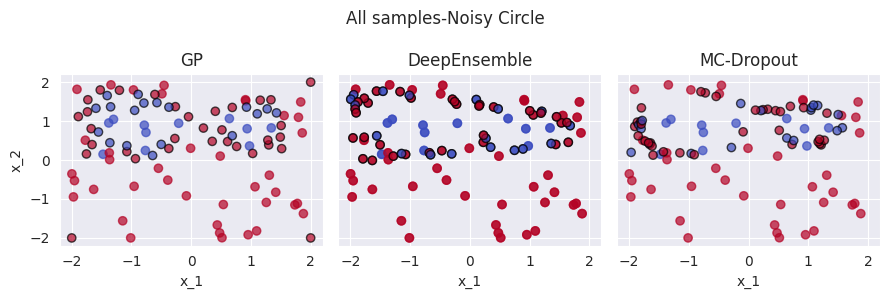

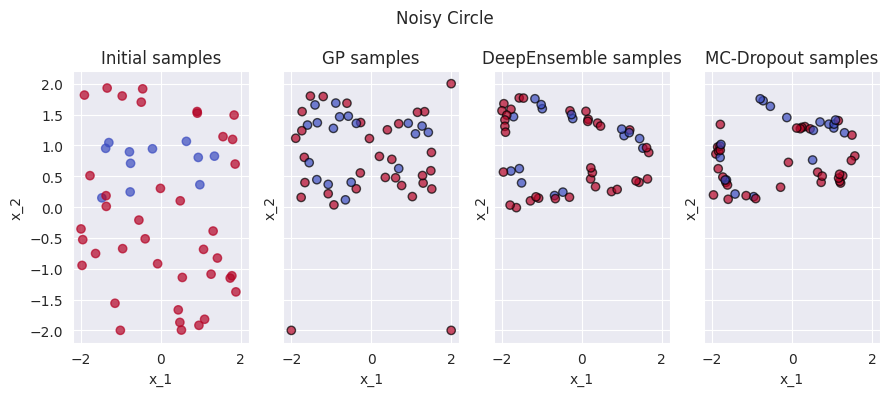

In [41]:
fig, ax = plt.subplots(figsize=(9, 3), ncols=3, sharey=True, sharex=True)
ax[0].scatter(qp_df_init['x_1'], qp_df_init['x_2'], c=qp_df_init['observation'],
            cmap='coolwarm', alpha=0.7, label='init_samples')
ax[0].scatter(qp_dfs['x_1'], qp_dfs['x_2'], c=qp_dfs['observation']+2,
              cmap='coolwarm', alpha=0.7, label='GP_collected_samples',
              edgecolors='black')
ax[1].scatter(qp_df_init['x_1'], qp_df_init['x_2'], c=qp_df_init['observation'],
            cmap='coolwarm', alpha=0.7, label='init_samples')
ax[1].scatter(qp_dfs_ensemble['x_1'], qp_dfs_ensemble['x_2'], c=qp_dfs['observation']+2,
              cmap='coolwarm', alpha=0.7, label='DE_collected_samples',
              edgecolors='black')
ax[1].scatter(qp_df_init['x_1'], qp_df_init['x_2'], c=qp_df_init['observation'],
            cmap='coolwarm', alpha=0.7, label='init_samples')
ax[1].scatter(qp_dfs_ensemble['x_1'], qp_dfs_ensemble['x_2'], c=qp_dfs['observation']+2,
              cmap='coolwarm', alpha=0.7, label='DE_collected_samples',
              edgecolors='black')

ax[2].scatter(qp_df_init['x_1'], qp_df_init['x_2'], c=qp_df_init['observation'],
            cmap='coolwarm', alpha=0.7, label='init_samples')
ax[2].scatter(qp_dfs_dropout['x_1'], qp_dfs_dropout['x_2'], c=qp_dfs['observation']+2,
              cmap='coolwarm', alpha=0.7, label='MC-dropout_collected_samples',
              edgecolors='black')
ax[0].set_xlabel('x_1')
ax[1].set_xlabel('x_1')
ax[2].set_xlabel('x_1')

ax[0].set_ylabel('x_2')

ax[0].set_title("GP")
ax[1].set_title("DeepEnsemble")
ax[2].set_title("MC-Dropout")

fig.suptitle("All samples-Noisy Circle")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(9, 4), ncols=4, sharey=True, sharex=True)
ax[0].scatter(init_df['x_1'], init_df['x_2'], c=init_df['observation'],
            cmap='coolwarm', alpha=0.7, label='init_samples')
ax[1].scatter(qp_dfs['x_1'], qp_dfs['x_2'], c=qp_dfs['observation']+2,
            cmap='coolwarm', alpha=0.7, label='collected_samples',
           edgecolors='black')
ax[2].scatter(qp_dfs_ensemble['x_1'], qp_dfs_ensemble['x_2'], c=qp_dfs_ensemble['observation']+2,
            cmap='coolwarm', alpha=0.7, label='collected_samples',
           edgecolors='black')
ax[3].scatter(qp_dfs_dropout['x_1'], qp_dfs_dropout['x_2'], c=qp_dfs_dropout['observation']+2,
            cmap='coolwarm', alpha=0.7, label='collected_samples',
           edgecolors='black')
ax[0].set_xlabel('x_1')
ax[1].set_xlabel('x_1')
ax[2].set_xlabel('x_1')
ax[3].set_xlabel('x_1')

ax[0].set_ylabel('x_2')
ax[1].set_ylabel('x_2')
ax[2].set_ylabel('x_2')
ax[3].set_ylabel('x_2')

ax[0].set_title("Initial samples")
ax[1].set_title("GP samples")
ax[2].set_title("DeepEnsemble samples")
ax[3].set_title("MC-Dropout samples")

fig.suptitle("Noisy Circle")
fig.tight_layout()
plt.show()